# Análisis de imágenes de Sargazo

### Librerías

In [1]:
# Librería de OpenCV
import cv2
# Librería Numpy para Arrays y operaciones matriciales
import numpy as np
# Libreria para las gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Mapa de colores
from PIL import Image #Procesamiento de imagenes

from scipy.ndimage import convolve #Convolucion
from scipy.fft import fft2, ifft2, fftshift #Transformadas de Fourier

from skimage.color import label2rgb #Colorear las etiquetas en una imagen segmentada

#Filtros
from skimage.filters import sobel,laplace,unsharp_mask

#Segmentacion
from skimage.segmentation import watershed
from skimage import util

### Funciones para cargar y mostrar imagenes

In [2]:
#Funcion que recibebe la direccion de la carpeta con las imagenes muestra, con un nombre base seguido de un arreglo de numeros y el tipo de archivo (debe ser la misma)
def ReadImg(folderPath,baseName,samples,fileExtension):
    images = list() #Se crea una lista vacia para contener las imagenes
    for i in samples: #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            images.append(Image.open(filePath).convert("HSV")) #Se intenta agregar la imagen en formato HSV
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return images #Se regresa una lista de imagenes

In [3]:
#Mostrar varias imagenes en una sola figura
def showNImg(imgList):
    fig, plots = plt.subplots(1,len(imgList)) #Se crean las graficas en una lista de subplots

    for i in range(0,len(imgList)):
        plots[i].imshow(imgList[i]) #Se muestra cada imagen de entrenamiento

In [4]:
#Funcion para obtener las imagenes de entrenamiento con la mascara de recorte a partir del canal alpha.
def ReadAlpha(folderPath,baseName,samples,fileExtension):
    #images = list() #Se crea una lista vacia para contener las imagenes
    alphas = list() #Se crea una lista vacia para contener los canales alpha
    for i in range(1,samples+1): #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            img = Image.open(filePath) #Se guarda la imagen en una variable
            #images.append(np.array(img.convert("HSV")))
            alpha = np.asarray(img.split()[-1]) #Se extrae el canal alpha
            alphas.append(alpha) #Se agrega la mascara a la lista
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return alphas #Se regresa una lista de imagenes

## Pruebas con la iluminación

Se tomaron tres imágenes de prueba con distinta iluminación y tamaño del cuerpo de sargazo, para poder determinar de manera empírica qué filtros podrían facilitar la detección.

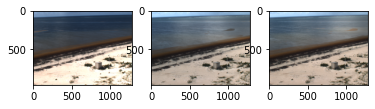

In [5]:
imges = ReadImg('Test/','Test',[1,2,3],'.png')
showNImg(imges)

Se tomó una de las imágenes de prueba para comprobar en qué canal HSV se puede observar mejor el sargazo y adicionalmente se le aplicó un filtro (Unsharp Masking) para realzar los bordes. El canal HUE parece separar mejor las regiones grandes con sargazo, mientras que el canal Saturation marca mejor los bordes de las olas para diferenciarlo en texturas del sargazo. En el canal Value no se aprecian muy bien las manchas de sargazo, pues tiene que ver más con la incidencia de la luz sobre los cuerpos.

<Figure size 432x288 with 0 Axes>

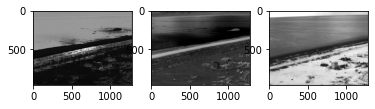

In [6]:
#Se toma una imagen cualquiera
testImg = np.array(imges[2])
#Se le aplica Unsharp Masking a la imagen de prueba. Con multichanel en True se especifica que es una imagen de distintos canales, de otra forma aplica el filtro para cada canal
testImg = unsharp_mask(testImg,radius=3,amount=0.1,multichannel=False)

#Se muestra la imagen en escala de grises
plt.gray()
#Se muestra la imagen en sus tres canales por separado; Hue, Saturation, Value, respectivamente.
showNImg([testImg[:,:,0],testImg[:,:,1],testImg[:,:,2]])

## Prueba de segmentación en el canal "Saturation" con un filtro Sobel

Ya que el canal Saturation parece ser en el que mejor se resaltan los bordes, se utilizó para aplicar un filtro Sobel, de tal forma que se apreciara mejor la diferencia de texturas entre el mar y las manchas de sargazo.

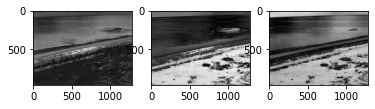

In [7]:
#Se aplica el filtro sobel a la imagen en sus tres canales. Se cambia el tipo de float para que sea compatible con la segmentacion en superpixeles mas adelante.
test2 = np.float32(sobel(testImg))
#Se muestran los tres canales de la imagen con filtro sobel. Se aprecia que el canal Saturation se distinguen mejor las manchas de sargazo.
showNImg([test2[:,:,0],test2[:,:,1],test2[:,:,2]])

### Usando superpixeles

In [20]:
#Funcion para segmentar una imagen en superpixeles
#img - imagen a segmentar
#size - tamaño del superpixel
#compact - compacidad del superpixel
def imagetoSP(img,size,compact):
    # Crear el objeto de SLIC con las propiedades especificadas
    slic = cv2.ximgproc.createSuperpixelSLIC(img, algorithm = cv2.ximgproc.SLIC, region_size = size, ruler = compact)
    # Iterar el algoritmo
    slic.iterate()
    # Obtener la máscara de los ejes de los Super pixeles
    mask_slic = slic.getLabelContourMask()
    # Obtener un numpy array con los indices de los superpixeles
    label_slic = slic.getLabels()
    # Obtener el número de Super pixeles generados
    number_slic = slic.getNumberOfSuperpixels()
    # Negar la máscara de los superpixeles para poder haceer operaciones con esta
    mask_inv_slic = cv2.bitwise_not(mask_slic)  
    # Hacer la operación booleana de la máscara de Super Pixeles y la imagen original
    img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic)
    # RESULTADOS
    return img_slic, label_slic, number_slic

In [21]:
#Funcion para obtener los superpixeles que se encuentran dentro de la mascara de recorte
def nonZeroSPixels(labels,Spixels,Aimage,bias): #Entradas: indices de los superpixeles, numero de superpixeles, alpha de la imagen, umbral de aceptacion
    pixels = [] #Se crea una lista para los indices de los superpixeles
    for i in Spixels: #Para cada superpixel
        Spixel = Aimage[np.where(labels==i)] #Obtenemos los pixeles que pertenencen a un respectivo superpixel
        rel = np.count_nonzero(Spixel)/len(Spixel) #Obtenemos la proporcion de pixeles dentro de la mascara de recorte
        if rel>=bias: #Si la proporcion de pixeles dentro de la mascara de recorte es mayor a un umbral
            pixels.append(i) #Guardar en la lista
    return pixels #Regresar indices de superpixeles aceptados

Como observamos que en el canal S de la imagen con filtro Sobel se apreciaba mejor el sargazo, lo utilizaremos para la segmentacion con superpíxeles.

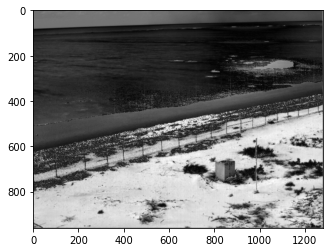

In [22]:
#Tomamos el canal S de la imagen con filtro sobel
sharpImg = test2[:,:,1]
#Vista previa del canal S
plt.imshow(sharpImg,cmap=cm.gray)

Numero de superpixeles 768


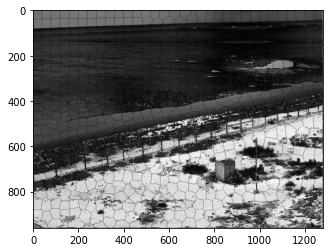

In [28]:
#Separamos la imagen en superpixeles
slicIm, lblSlic, n_Slic = imagetoSP(sharpImg,40,0.05)
print("Numero de superpixeles",n_Slic)
#Vista previa de la imagen segmentada en superpixeles
plt.imshow(slicIm,cmap=cm.gray)
#color1 = label2rgb(lblSlic, image=segImg, bg_label=-1)

#### Discriminando zonas

Ya que la cámara parece estar todo el tiempo en el mismo lugar y que las zonas ocupan los mismos píxeles, podemos reducir las zonas de análisis.

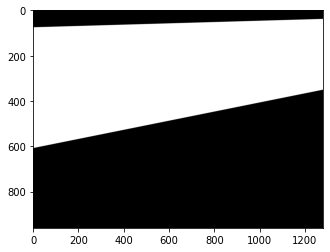

In [29]:
#Se abre la imagen con la mascara de referencia
base = Image.open("Mar_mask.png")
#La mascara se encuentra en el canal alpha, por lo que solo extraeremos esa parte
base = np.asarray(base.split()[-1])
#Vista previa de la mascara base
plt.imshow(base,cmap=cm.gray)

In [30]:
#Se obtienen los superpixeles que se encuentran dentro de la mascara base
validPixels = nonZeroSPixels(lblSlic,range(n_Slic),base,0.5)
print("Superpixeles resultantes",len(validPixels))

Superpixeles resultantes 333


In [33]:
#Para visualizar mejor el resultado de quitar los superpixeles no validos (que no se encuentran dentro de la mascara)
maskedImg=np.zeros(sharpImg.shape)
for i in validPixels:
    ind = np.where(lblSlic==i)
    ind = list(map(tuple, np.array(ind).T))
    for x,y in ind:
        maskedImg[x,y]=slicIm[x,y]

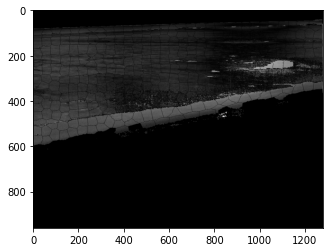

In [32]:
#Se muestran los superpixeles validos
plt.imshow(maskedImg,cmap=cm.gray)

### GLCM con cualquier escala y un determinado numero de niveles

In [270]:
#image - imagen para analizar texturas
#indexes - indices de los pixeles dentro de la textura
#maxVal - nivel maximo de gris
#n - numero de niveles de gris
#offset - distancia al siguiente pixel
#angle - angulo al siguiente pixel (de 0 a 3.141592)
def GLCMmat(image,indexes,maxVal,n,offset,angle):
    #Creamos una matriz de ceros para inicializar la matriz GLCM
    M = np.zeros((n,n), dtype=np.uint8)
    #Obtenermos los pixeles que contienen la textura
    pixels=image[indexes]
    n_indexes = list(map(tuple, np.array(indexes).T))
    #Obtenemos los pasos hacia el siguiente pixel
    dx = np.int8(offset * np.cos(angle))
    dy = np.int8(offset * np.sin(angle))
    #Para cada nivel de gris
    for a in range(n):
        #Buscamos los indices de los pixeles que corresponden a ese nivel (inclusivo el 0 y el valor maximo)
        if(a==0):
            current_indexes = np.where(np.logical_and(pixels>=maxVal * a / n, pixels<=maxVal * (a+1) / n))
        else:
            current_indexes = np.where(np.logical_and(pixels>(maxVal/n * a), pixels<=(maxVal/n * (a+1))))
            
        #Si no hay pixeles dentro de ese nivel, pasar al siguiente
        if(len(current_indexes[0])==0):
            continue
        #Los transformamos de una tupla de listas a una lista de tuplas para iterarlos
        current_indexes = list(map(tuple, np.array(current_indexes).T))
        #Por cada pixel de ese nivel de gris
        for v_i, in current_indexes:
            #print(v_i)
            x,y=n_indexes[v_i]
            #Si el siguiente pixel se encuentra dentro de los limites de la imagen
            if(x+dx>=0 and x+dx<image.shape[0] and y+dy>=0 and y+dy<image.shape[1]):
                #Para el nivel de gris del siguiente pixel
                for b in range(n):
                    #Si el siguiente pixel de la imagen se encuentra en el nivel de gris
                    if(image[x+dx,y+dy]>=(maxVal/n * b) and image[x+dx,y+dy]<=(maxVal/n * (b+1))):
                        #Sumar el conteo de la matriz GLCM y terminar el ciclo for (pasar al siguiente pixel)
                        M[a,b]+=1
                        break
    #La salida es la matriz GLCM simetrica
    return M+M.T

In [323]:
#Funcion para obtener alguna propiedad GLCM
def computeFeatures(GLCM):
    GLCM = GLCM/np.sum(GLCM)
    scale_gray = GLCM.shape[0]
    # Medidas a obtener relacionadas al contraste
    # con_m --- Contrast, sum of squares variance or inertia
    # dis_m --- Dissimilarity
    # idm_m --- Homogeneity or Inverse Difference Moment
    con_m, dis_m, idm_m = 0, 0, 0
    # Medidas a obtener relacionadas al orden
    # asm_m --- Angular Second Moment
    # ene_m --- Energy
    # ent_m --- Entropy    
    asm_m, ene_m, ent_m = 0, 0, 0    
    # Medidas a obtener relacionadas a la estadística descriptiva
    # mhu_m -- GLCM Mean i & j are equal for symmetrical GLCM
    # var_m -- GLCM Variance i & j are equal for symmetrical GLCM
    # cor_m -- Correlation
    mhu_m, var_m, cor_m = 0, 0, 0    
    # Recorrer la matriz GLCM para obtener medidas de contraste y orden
    for i in range(scale_gray):
        for j in range(scale_gray):
            con_m += GLCM[i,j] * ((i-j)**2)
            dis_m += GLCM[i,j] * abs(i-j)
            idm_m += GLCM[i,j] / (1 + ((i-j)**2))
            asm_m += GLCM[i,j]**2
            if GLCM[i,j] > 0:
                ent_m += GLCM[i,j] * (-np.log(GLCM[i,j]))
            mhu_m += GLCM[i,j] * i
    ene_m = asm_m **(1/2)
#     # Recorrer la matriz GLCM por segunda vez para obtener medidas de estadística descriptiva
#     for i in range(scale_gray + 1):
#         for j in range(scale_gray + 1):
#             var_m += GLCM[i,j] * (i - mhu_m)**2
#     # Recorrer la matriz GLCM por tercera vez para obtener medidas de estadística descriptiva
#     for i in range(scale_gray + 1):
#         for j in range(scale_gray + 1):
#             cor_m += GLCM[i,j] * (((i-mhu_m)*(j-mhu_m))/(var_m))       

#     print(f"Medidas obtenidas--------")
#     print(f"Contraste      = {con_m}")
#     print(f"Disimilitud    = {dis_m}")
#     print(f"Homogeneidad   = {idm_m}")
#     print(f"ASM            = {asm_m}")
#     print(f"Energia        = {ene_m}")
#     print(f"Entropía       = {ent_m}\n")
#     print(f"Promedio i o j = {mhu_m}")
#     print(f"Varianza i o j = {var_m}")
#     print(f"Correlación    = {cor_m}")
    return [con_m, dis_m, idm_m, ene_m, ent_m]

In [324]:
print(n_Slic)
for i in range(3):
    pixels = np.where(lblSlic==(i+1))
    glcm = GLCMmat(testImg[:,:,1],pixels,1.0,10,2,3.141592/3)
    print(computeFeatures(glcm))
    

1938
[1.1923076923076923, 0.7461538461538461, 0.6708144796380089, 0.3419690055969323, 2.376154716781753]
[1.2713347921225384, 0.899343544857768, 0.587527352297593, 0.28102618970407306, 2.7341446886386205]
[1.5048076923076923, 0.980769230769231, 0.5616798642533939, 0.319327234324542, 2.5011369272423116]


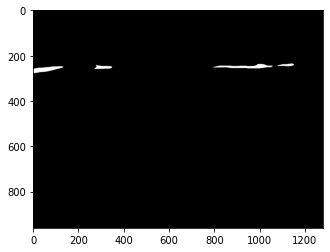

In [82]:
training = ReadImg('Training/','Color',range(1,24),'.png')
mask = ReadAlpha("Training/","Train",23,".png")
plt.imshow(mask[0], cmap=cm.gray)
#print(np.array(train[0]).shape)
#print(np.ma.array(train[0][:,:,0], mask = mask[0])[250:260,:10])